<a href="https://colab.research.google.com/github/nilsugungor/titanic-analysis/blob/main/titanic_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import kagglehub
path = kagglehub.dataset_download("yasserh/titanic-dataset")

Using Colab cache for faster access to the 'titanic-dataset' dataset.


In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
df = pd.read_csv(os.path.join(path, "Titanic-Dataset.csv"))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
#handle missing values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

In [ ]:
#sibling spouse // parent children
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

In [ ]:
#binning age groups
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 12, 20, 40, 60, 100],
    labels=["Child", "Teen", "Adult", "Middle", "Senior"]
)


In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [20]:
corr = df.corr(numeric_only=True)
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: ylabel='count'>

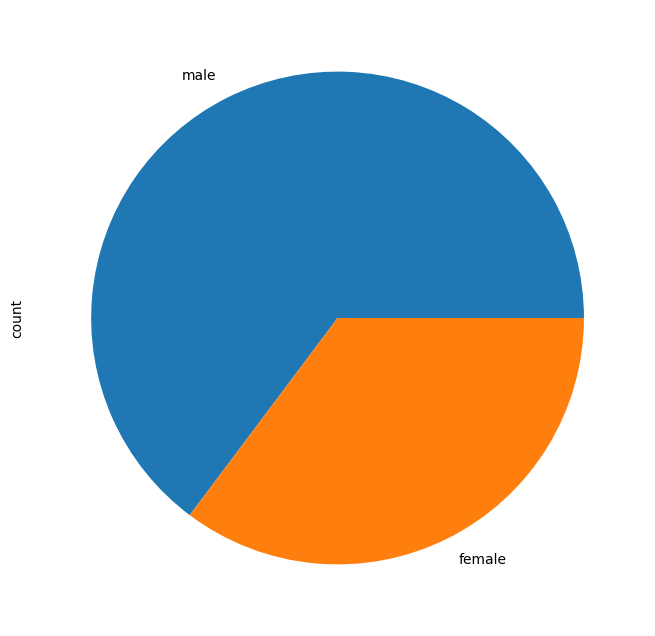

In [10]:
df["Sex"].value_counts().plot(kind='pie', figsize=(8, 8))

In [ ]:
#encoding sex
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [ ]:
#one hot encoding categorical features
df = pd.get_dummies(df, columns=["AgeGroup", "Embarked"], drop_first=True)

In [ ]:
#select features and target
X = df[
    ["Pclass", "Sex", "Age", "FamilySize"] +
    [col for col in df.columns if col.startswith("AgeGroup_") or col.startswith("Embarked_")]
].copy()

y = df["Survived"]

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#check for nulls
pd.DataFrame(X_train).isnull().sum()


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
#check for infinites
np.isinf(X_train).sum()


np.int64(0)

In [ ]:
#training the model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#prediction and evaluation
#accuracy is expected, slightly worse compared to random forest model
#false negative and positive almost equal, balanced errors
#recall a bit lower for survivors expected because there are less survivors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8156424581005587

Confusion Matrix:
 [[89 16]
 [17 57]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [ ]:
#model coefficients
#being female increases the survival directly, higher class number means lower survival
#larger families have lower survival
#children are the reference group, everyone else has a lower survival rate than children
#embarking place doesn't have that much effect
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logreg.coef_[0]
})

print("\nFeature Coefficients:")
print(coefficients.sort_values(by="Coefficient", ascending=False))


Feature Coefficients:
           Feature  Coefficient
1              Sex     1.340885
8       Embarked_Q    -0.075855
2              Age    -0.142514
7  AgeGroup_Senior    -0.226344
9       Embarked_S    -0.236370
3       FamilySize    -0.525075
4    AgeGroup_Teen    -0.610181
6  AgeGroup_Middle    -0.645130
5   AgeGroup_Adult    -0.789088
0           Pclass    -0.818732
